# Comparison of different bias mitigation methods on accuracy and bias metrics

The goal of this analysis is to make a comparison of different bias mitigation methods for classification problems on different types of dataset and to see how these methods impact on different fairness metrics and on the accuracy of the classifier. The datasets on which we will test the fairness algorithms are:

1. Unbias dataset
2. Bias unbalanced dataset
3. Bias balanced dataset

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from numpy.random import default_rng
from collections import OrderedDict
from copy import deepcopy
sns.set_theme()

from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels

In [3]:
# utility functions
def compute_dataset_fairness_metrics(data: BinaryLabelDataset, unpriv_group: list, priv_group: list):
    """ Computes: Disparate Impact and Statistical Parity """
    
    b = BinaryLabelDatasetMetric(data, unprivileged_groups=unpriv_group, privileged_groups=priv_group)
    metrics = dict()
    metrics['Disparate Impact'] = b.disparate_impact()
    metrics['Statistical Parity'] = b.statistical_parity_difference()
    for k in metrics:
        print("%s = %.4f" % (k, metrics[k]))
    return metrics

def compute_fairness_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Computes: Balanced Accuracy 
    Statistical Parity Difference
    Disparate Impact
    Average odds difference
    Equal Opportunity Difference
    Theil Index """
    
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

def compute_quality_metrics(dataset_true, dataset_pred, unprivileged_group, privileged_group):
    clm = ClassificationMetric(dataset_true, dataset_pred, unprivileged_group, privileged_group)
    p_metrics = OrderedDict()
    u_metrics = OrderedDict()
    p_metrics['Precision'] = clm.precision(privileged=True)
    p_metrics['Recall'] = clm.recall(privileged=True)
    p_metrics['F1 Score'] = (2*p_metrics['Precision']*p_metrics['Recall'])/(p_metrics['Precision']+p_metrics['Recall'])
    
    u_metrics['Precision'] = clm.precision(privileged=False)
    u_metrics['Recall'] = clm.recall(privileged=False)
    u_metrics['F1 Score'] = (2*u_metrics['Precision']*u_metrics['Recall'])/(u_metrics['Precision']+u_metrics['Recall'])
    return p_metrics, u_metrics

def build_dataset(n_samples, n_features, n_informative, n_sensitive):
    """"Builds a syntetic dataset for classification"""
    x, y = make_classification(n_samples=n_samples, 
                               n_features=n_features, 
                               n_informative=n_informative)
    data = pd.DataFrame(np.column_stack((x,y)), columns=[i for i in range(11)])
    s = np.arange(n_sensitive)
    s = np.repeat(s,n_samples/2)
    rnd = default_rng()
    rnd.shuffle(s)
    data['s'] = s
    return data

def split_data(data: BinaryLabelDataset):
    #data = BinaryLabelDataset(df=data, label_names=label_names, protected_attribute_names=protect_attr_names)
    data_train, data_tv = data.split([0.7], shuffle=True)
    data_test, data_valid = data_tv.split([0.5], shuffle=True)
    return data_train, data_test, data_valid

def x_y_split_dir(train, test):
    x_train = np.delete(train.features, train.feature_names.index('s'), axis=1)
    y_train = train.labels.ravel()
    x_test = np.delete(test.features, test.feature_names.index('s'), axis=1)
    y_test = test.labels.ravel()
    return x_train, y_train, x_test, y_test

def x_y_split(data_train: BinaryLabelDataset, data_test: BinaryLabelDataset):
    X_train = data_train.features
    Y_train = data_train.labels.ravel()
    X_test = data_test.features
    Y_test = data_test.labels.ravel()
    return X_train, Y_train, X_test, Y_test

def compute_classification_metrics(estimator: Pipeline, valid_data: BinaryLabelDataset):
    
    """"Computes the bias classification metrics 
    in addition to the classification report and a confusion matrix"""
    pred = valid_data.copy()
    pred.labels = estimator.predict(pred.features)
    plot_classification_report(classification_report(valid_data.labels, pred.labels))
    plot_confusion_matrix(valid_data.labels, pred.labels, {'1', '0'}, normalize=True)
    class_metrics = compute_fairness_metrics(valid_data, pred, unprivileged_group, privileged_group)
    return class_metrics

def merge_datasets(datasets: dict):
    keys = list(datasets.keys())
    first_data = datasets.pop(keys[0])
    merged_metrics = pd.DataFrame(first_data, index=[0])
    merged_metrics.loc[0,'Dataset'] = keys[0]
    index = 1
    for k,v in datasets.items():
        merged_metrics = merged_metrics.append(v, ignore_index=True)
        merged_metrics.loc[index,'Dataset'] = k
        index = index + 1
    merged_data = merged_metrics.melt(id_vars='Dataset', value_name='values', var_name='metrics')
    return merged_data

In [4]:
def classify_dir(estimator: Pipeline, data: BinaryLabelDataset, show=True):
    np_data = np.hstack((data.features, data.labels))
    kf = KFold(n_splits=10, shuffle=True)
    class_metrics = []
    quality_metrics_p = []
    quality_metrics_u = []
    for train, test in kf.split(np_data):
        d_train = data.subset(train)
        d_test = data.subset(test)
        x_train, y_train, x_test, y_test = x_y_split_dir(d_train, d_test)
        d_test.features = np.delete(d_test.features, d_test.feature_names.index('s'), axis=1)
        pipe = deepcopy(estimator)
        pipe.fit(x_train, y_train, logisticregression__sample_weight=d_train.instance_weights.ravel())
        pred = d_test.copy()
        pred.labels = pipe.predict(x_test)
        metric = compute_fairness_metrics(d_test, pred, unprivileged_group, privileged_group, disp=False)
        q_metric_p, q_metric_u = compute_quality_metrics(d_test, pred, unprivileged_group, privileged_group)
        quality_metrics_p.append(q_metric_p)
        quality_metrics_u.append(q_metric_u)
        class_metrics.append(metric)
    
    ris = {key: round(np.mean([metric[key] for metric in class_metrics]),4) for key in class_metrics[0]}
    q_metrics_p = {key: round(np.mean([metric[key] for metric in quality_metrics_p]),4) for key in quality_metrics_p[0]}
    q_metrics_u = {key: round(np.mean([metric[key] for metric in quality_metrics_u]),4) for key in quality_metrics_u[0]}
    q_metrics = pd.DataFrame(data=[q_metrics_p, q_metrics_u], index=['Privileged', 'Unprivileged'])
    plot_quality_metrics(q_metrics)
    if show:
        for key, val in ris.items():
            print("%s: %.4f" % (key,val))
    return ris

def classify_rw(estimator: Pipeline, data: BinaryLabelDataset, show=True):
    np_data = np.hstack((data.features, data.labels))
    kf = KFold(n_splits=10, shuffle=True)
    class_metrics = []
    quality_metrics_p = []
    quality_metrics_u = []
    for train, test in kf.split(np_data):
        d_train = data.subset(train)
        d_test = data.subset(test)
        x_train, y_train, x_test, y_test = x_y_split(d_train, d_test)
        pipe = deepcopy(estimator)
        pipe.fit(x_train, y_train, logisticregression__sample_weight=d_train.instance_weights.ravel())
        pred = d_test.copy()
        pred.labels = pipe.predict(x_test)
        metric = compute_fairness_metrics(d_test, pred, unprivileged_group, privileged_group, disp=False)
        q_metric_p, q_metric_u = compute_quality_metrics(d_test, pred, unprivileged_group, privileged_group)
        quality_metrics_p.append(q_metric_p)
        quality_metrics_u.append(q_metric_u)
        class_metrics.append(metric)

    ris = {key: round(np.mean([metric[key] for metric in class_metrics]),4) for key in class_metrics[0]}
    q_metrics_p = {key: round(np.mean([metric[key] for metric in quality_metrics_p]),4) for key in quality_metrics_p[0]}
    q_metrics_u = {key: round(np.mean([metric[key] for metric in quality_metrics_u]),4) for key in quality_metrics_u[0]}
    q_metrics = pd.DataFrame(data=[q_metrics_p, q_metrics_u], index=['Privileged', 'Unprivileged'])
    plot_quality_metrics(q_metrics)
    if show:
        for key, val in ris.items():
            print("%s: %.4f" % (key,val))
    return ris

In [5]:
# plot functions

def plot_confusion_matrix(cm,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = {'1', '0'}
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_quality_metrics(q_metrics):
    ax = sns.heatmap(q_metrics, annot=True, cmap=plt.cm.RdBu)
    plt.ylabel('Classes')
    plt.xlabel('Metrics')
    plt.yticks(rotation=0)
    plt.title('Classification Report')
    plt.tight_layout()
    return ax

def plot_classification_report(classificationReport,
                               title='Classification report',
                               cmap='RdBu'):

    classificationReport = classificationReport.replace('\n\n', '\n')
    classificationReport = classificationReport.replace(' / ', '/')
    lines = classificationReport.split('\n')

    classes, plotMat, support, class_names = [], [], [], []
    for line in lines[1:-4]:  # if you don't want avg/total result, then change [1:] into [1:-1]
        t = line.strip().split()
        if len(t) < 2:
            continue
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        support.append(int(t[-1]))
        class_names.append(t[0])
        plotMat.append(v)

    plotMat = np.array(plotMat)
    xticklabels = ['Precision', 'Recall', 'F1-score']
    yticklabels = ['{0} ({1})'.format(class_names[idx], sup)
                   for idx, sup in enumerate(support)]

    plt.imshow(plotMat, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    plt.xticks(np.arange(3), xticklabels, rotation=45)
    plt.yticks(np.arange(len(classes)), yticklabels)

    upper_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 8
    lower_thresh = plotMat.min() + (plotMat.max() - plotMat.min()) / 10 * 2
    for i, j in itertools.product(range(plotMat.shape[0]), range(plotMat.shape[1])):
        plt.text(j, i, format(plotMat[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if (plotMat[i, j] > upper_thresh or plotMat[i, j] < lower_thresh) else "black")

    plt.ylabel('Metrics')
    plt.xlabel('Classes')
    plt.tight_layout()

def plot_metrics_comparison(bias_class_metrics, rw_class_metrics, title1='', title2=''):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    keys = list(bias_class_metrics.keys())
    vals = [float(bias_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[0])
    for k in keys:
        ax[0].text(keys.index(k), 
                   bias_class_metrics[k], 
                   round(bias_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    keys = list(rw_class_metrics.keys())
    vals = [float(rw_class_metrics[k]) for k in keys]
    sns.barplot(x=keys, y=vals,ax=ax[1])
    for k in keys:
        ax[1].text(keys.index(k), 
                   rw_class_metrics[k], 
                   round(rw_class_metrics[k], 3), 
                   ha="center",
                   va="bottom",
                   fontsize="medium"
                  )
    ax[0].tick_params(labelrotation=90)
    ax[0].set(title=title1)
    ax[1].tick_params(labelrotation=90)
    ax[1].set(title=title2)
    return ax

def plot_syntesis(dataset, title):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    unbias_fig = sns.barplot(data = dataset, x='metrics', y='values', hue='Dataset', ax=ax)
    plt.ylabel(ylabel='')
    plt.xlabel(xlabel='')
    plt.title(title)
    return ax

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the target variable at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the target variable $y$ are changed s.t. the mean of the $y$ distribution is the mean between the mean of $y$ distribution for the privileged and unprivileged groups. 
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier. 

<!--3. **LFR**

> Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data well but obfuscates information about protected attributes-->

## Dataset creation

Here we will create a binary labeled dataset with 10.000 samples and 11 features of which 4 are informative features and one will act as sensitive attribute:

In [6]:
n_samples = 10000
n_features = 10
n_informative = 4
n_sensitive = 2

In [7]:
data = pd.read_csv('synthetic/synthetic.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,10,s
0,1.117819,2.978286,0.446270,1.462078,-0.603682,-1.010214,-0.850477,-0.534090,2.619979,2.847635,1.0,0
1,-1.241114,0.966580,2.522553,2.197615,-2.049246,-2.272453,-0.912986,-1.074081,0.156897,-0.893949,0.0,0
2,1.499456,3.462662,-1.581721,-0.717028,0.706507,0.067985,1.081010,-1.360287,2.342430,2.600052,1.0,1
3,1.119152,-1.030551,2.154243,-1.041053,0.374413,-1.707872,1.508272,0.426323,-1.545117,-1.741156,0.0,0
4,0.951065,3.900728,0.127303,-0.075893,0.416828,-1.444766,-0.093549,-2.440322,2.097760,1.317815,0.0,1


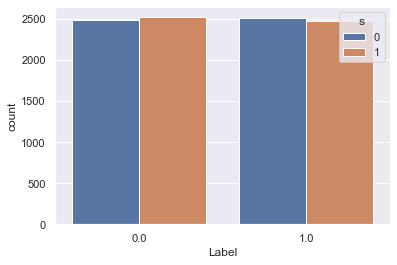

In [8]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

The dataset seems to be fair with respect to the sensitive attribute

In [83]:
unprivileged_group = [{'s': 0}]
privileged_group = [{'s': 1}]

# Unbias dataset

Here we will apply the metrics and the algorithms defined above on the unbias version of the dataset and compare how these bias mitigation algorithms change the different metrics.

## Dataset fairness metrics 

Let's compute the dataset fairness metrics defined above on the syntetic dataset to check that it is really unbias

In [84]:
bin_data = BinaryLabelDataset(df=data, label_names=['10'], protected_attribute_names=['s'])
metrics = compute_dataset_fairness_metrics(bin_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0161
Statistical Parity = 0.0080


The dataset is not bias.

## Classification bias metrics

Here we train and test a _Logistic Regression_ classifier:

Balanced accuracy: 0.7619
Statistical parity difference: 0.0179
Disparate impact: 1.0348
Average odds difference: 0.0138
Equal opportunity difference: 0.0174
Theil index: 0.1496


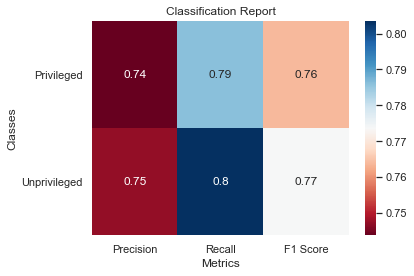

In [85]:
class_metrics = classify_rw(make_pipeline(StandardScaler(), LogisticRegression()), bin_data)

From the values of the metrics we can see that the classifier is fair and quite accurate. Let's now test the same metrics on a bias dataset.

## Reweighing

Here we apply the _Reweighing_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [86]:
rw_unbias_data = bin_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_unbias_data = rw.fit_transform(rw_unbias_data)

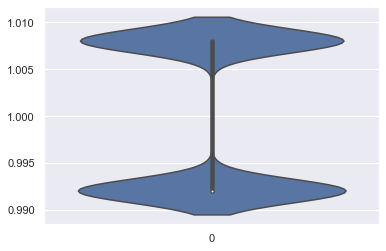

In [87]:
sns.violinplot(data=rw_unbias_data.instance_weights)
plt.show()

### Dataset metrics

In [88]:
metrics = compute_dataset_fairness_metrics(rw_unbias_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.7632
Statistical parity difference: 0.0025
Disparate impact: 1.0056
Average odds difference: 0.0023
Equal opportunity difference: 0.0059
Theil index: 0.1482


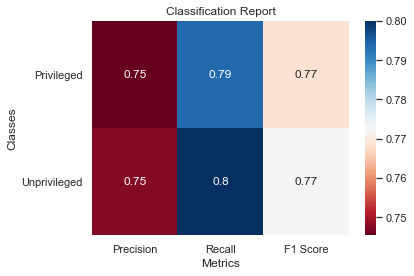

In [89]:
rw_un_metrics = classify_rw(make_pipeline(StandardScaler(), LogisticRegression()), rw_unbias_data)

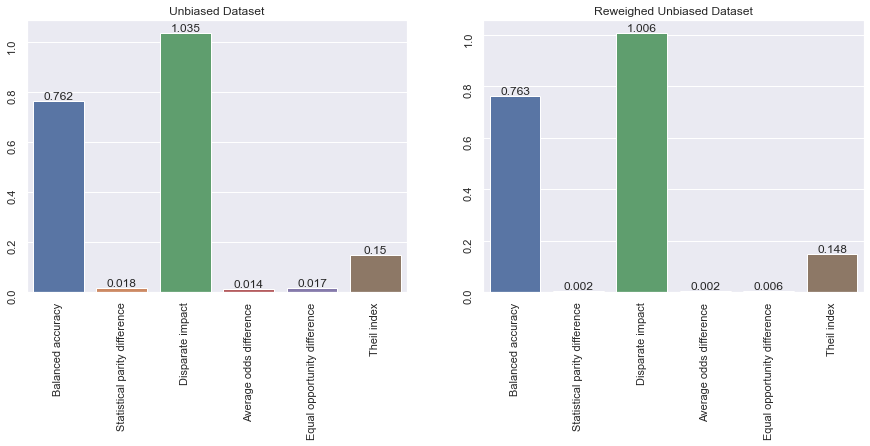

In [90]:
plot_metrics_comparison(class_metrics, rw_un_metrics, "Unbiased Dataset", "Reweighed Unbiased Dataset")
plt.show()

## Disparate Impact Remover

Here we apply the _Disparate Impact Remover_ algorithm to the unbiased dataset and see how this method impacts on the metrics defined above:

In [91]:
dir_unb_data = bin_data.copy()
scaler = MinMaxScaler(copy=False)
dir_unb_data.features = scaler.fit_transform(dir_unb_data.features)

In [92]:
di = DisparateImpactRemover(sensitive_attribute='s')
dir_unb_data = di.fit_transform(dir_unb_data)

### Dataset metrics

In [93]:
metrics = compute_dataset_fairness_metrics(dir_unb_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0161
Statistical Parity = 0.0080


### Classification metrics

Balanced accuracy: 0.7644
Statistical parity difference: 0.0038
Disparate impact: 1.0082
Average odds difference: 0.0001
Equal opportunity difference: 0.0031
Theil index: 0.1473


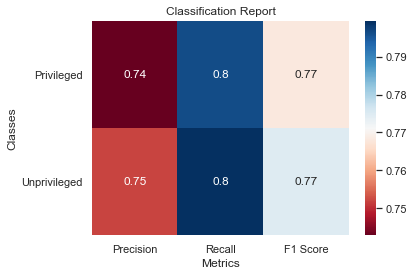

In [94]:
dir_fair_metrics = classify_dir(make_pipeline(StandardScaler(), LogisticRegression()), dir_unb_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


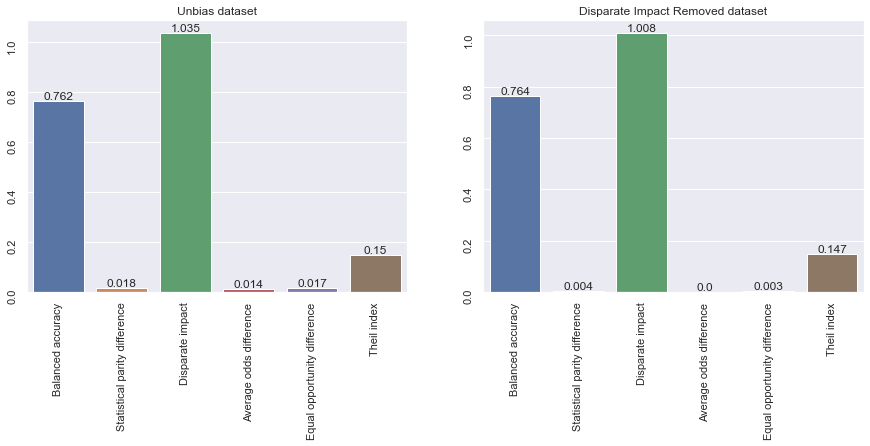

In [95]:
plot_metrics_comparison(class_metrics, dir_fair_metrics, "Unbias dataset", "Disparate Impact Removed dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In the following we compare the performances of _Reweighing_ and _Disparate Impact Remover_ on the unbias dataset. 

In [96]:
un_merged_metrics = merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


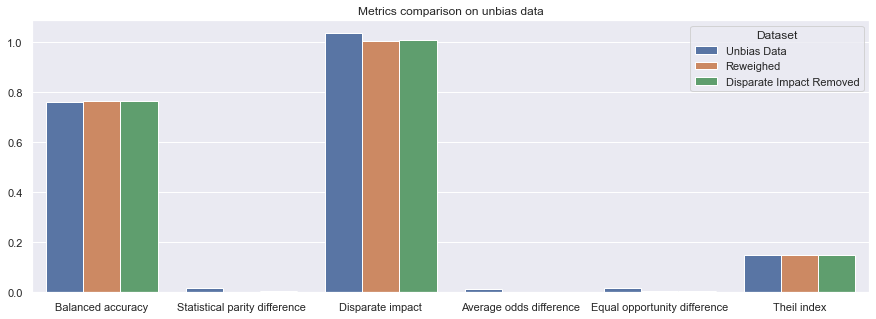

In [97]:
plot_syntesis(un_merged_metrics, 'Metrics comparison on unbias data')
plt.show()

# Unbalanced Bias dataset

Let's change the previous dataset adding a bias on the sensitive attribute `s` with value 0 and keeping the instances with `s=1` invariate:

In [98]:
bias_data = data.copy()
bias_data.loc[(bias_data['s'] == 0) & (bias_data.index < int(n_samples/2)) , '10'] = 0.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


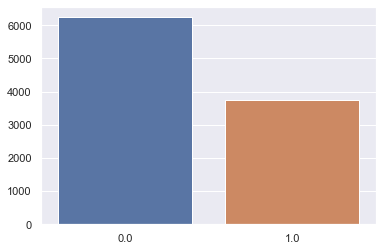

In [99]:
sns.barplot(x=bias_data['10'].value_counts().index, y=bias_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


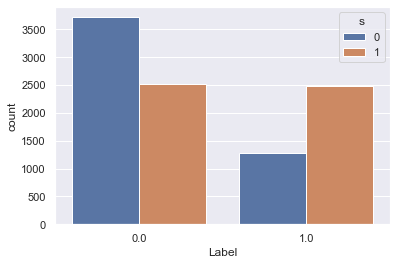

In [100]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

## Dataset fairness metrics

Let's compute the dataset fairness metrics on this new dataset:

In [101]:
bias_data_bin = BinaryLabelDataset(df = bias_data, label_names=['10'], protected_attribute_names=['s'])
bias_metrics = compute_dataset_fairness_metrics(bias_data_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.5174
Statistical Parity = -0.2392


## Classification bias metrics

Balanced accuracy: 0.7099
Statistical parity difference: -0.4183
Disparate impact: 0.2081
Average odds difference: -0.3986
Equal opportunity difference: -0.6142
Theil index: 0.2066


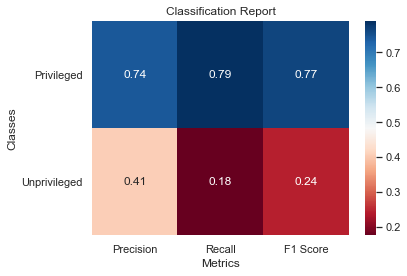

In [102]:
bias_class_metrics = classify_rw(make_pipeline(StandardScaler(), LogisticRegression()), bias_data_bin)

##  Reweighing

In [103]:
rw_data = bias_data_bin.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
rw_data = rw.fit_transform(rw_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


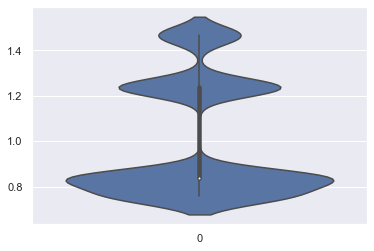

In [104]:
sns.violinplot(data=rw_data.instance_weights)
plt.show()

### Dataset metrics

In [105]:
rw_metrics = compute_dataset_fairness_metrics(rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


### Classification metrics

Balanced accuracy: 0.6535
Statistical parity difference: -0.0244
Disparate impact: 0.9284
Average odds difference: -0.0513
Equal opportunity difference: -0.1602
Theil index: 0.2395


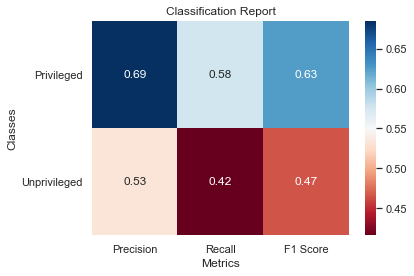

In [106]:
rw_class_metrics = classify_rw(make_pipeline(StandardScaler(), LogisticRegression()), rw_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


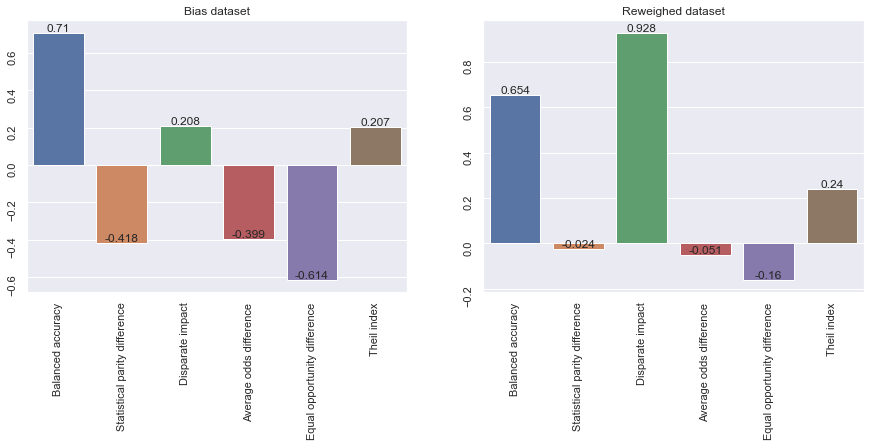

In [107]:
plot_metrics_comparison(bias_class_metrics, rw_class_metrics, "Bias dataset", "Reweighed dataset")
plt.show()

## Disparate Impact Remover

In [108]:
dir_data = bias_data_bin.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

In [109]:
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_data = dr.fit_transform(dir_data)

### Dataset metrics

In [110]:
dir_metrics = compute_dataset_fairness_metrics(dir_data, unprivileged_group, privileged_group)

Disparate Impact = 0.5174
Statistical Parity = -0.2392


### Classification metrics

Balanced accuracy: 0.6393
Statistical parity difference: -0.0159
Disparate impact: 0.9525
Average odds difference: 0.0344
Equal opportunity difference: -0.0345
Theil index: 0.2618


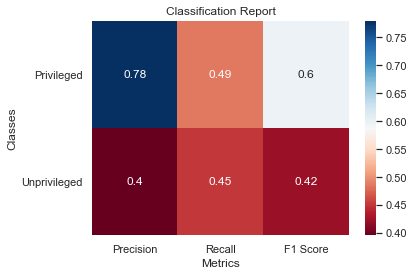

In [111]:
dir_class_metrics = classify_dir(make_pipeline(StandardScaler(), LogisticRegression()), dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


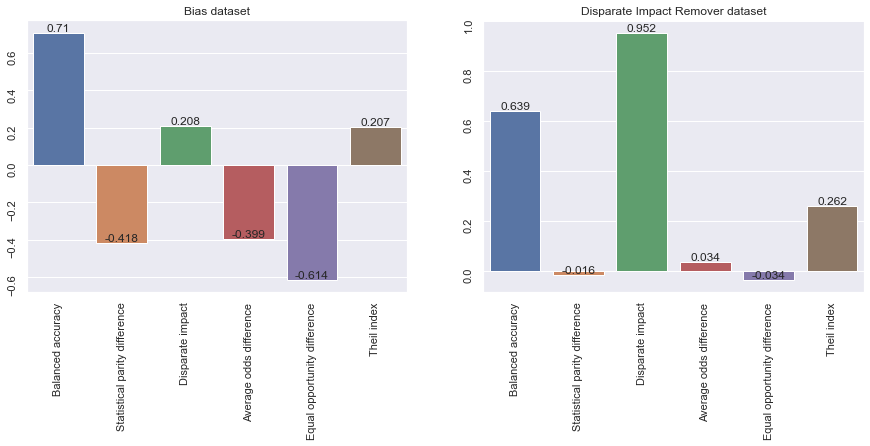

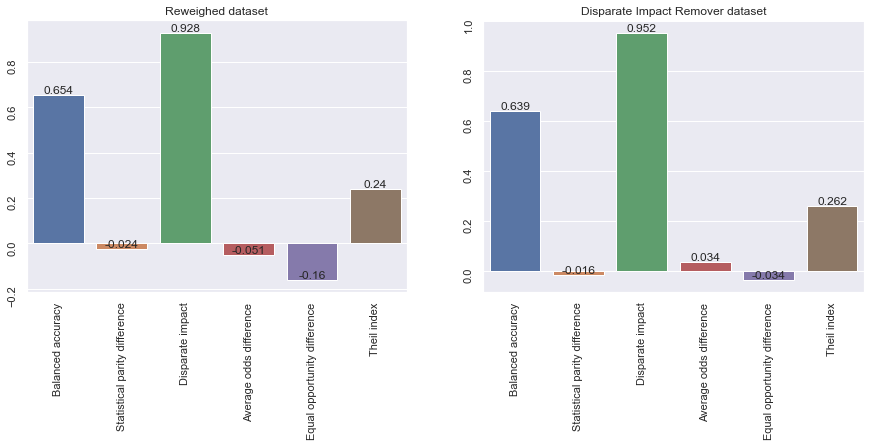

In [112]:
plot_metrics_comparison(bias_class_metrics, dir_class_metrics, "Bias dataset", "Disparate Impact Remover dataset")
plot_metrics_comparison(rw_class_metrics, dir_class_metrics, "Reweighed dataset", "Disparate Impact Remover dataset")
plt.show()

## Reweighing vs Disparate Impact Remover

In [113]:
unbal_merged_metrics = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


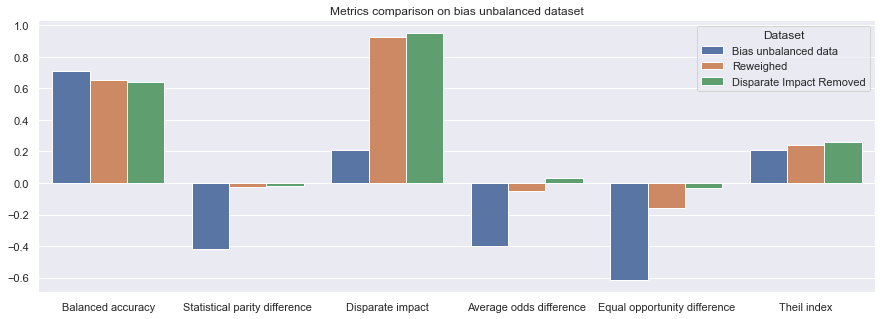

In [114]:
plot_syntesis(unbal_merged_metrics, 'Metrics comparison on bias unbalanced dataset')
plt.show()

# Bias balanced dataset

Let's balance the previous dataset changing the labels of half of the samples with `s=1` to `1.0`

In [115]:
bias_bal_data = bias_data.copy()
bias_bal_data.loc[(bias_data['s'] == 1) & (bias_data.index < int(n_samples/2)) & (bias_data['10']==0.0) , '10'] = 1.0

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


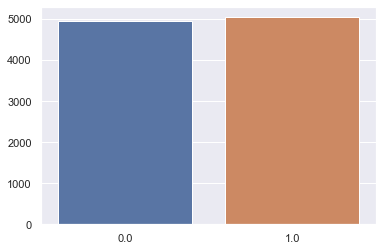

In [116]:
sns.barplot(x=bias_bal_data['10'].value_counts().index, y=bias_bal_data['10'].value_counts().values)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


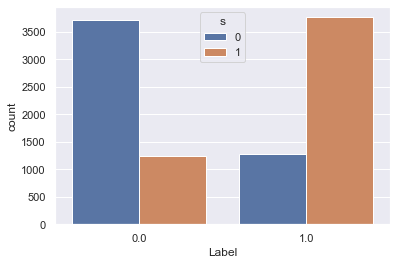

In [117]:
ax = sns.barplot(
    x='10', y='count', 
    hue='s', 
    data=bias_bal_data.groupby('s')['10'].value_counts().rename('count').reset_index(),
)
ax.set(xlabel= 'Label')
plt.show()

In [118]:
bias_bal_bin = BinaryLabelDataset(df=bias_bal_data, label_names=['10'], protected_attribute_names=['s'])

## Dataset metrics

In [119]:
bal_metrics = compute_dataset_fairness_metrics(bias_bal_bin, unprivileged_group, privileged_group)

Disparate Impact = 0.3406
Statistical Parity = -0.4964


## Classification metrics

Balanced accuracy: 0.7409
Statistical parity difference: -0.8868
Disparate impact: 0.0449
Average odds difference: -0.8591
Equal opportunity difference: -0.8897
Theil index: 0.1892


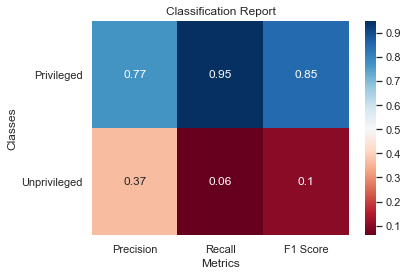

In [120]:
bias_bal_metrics = classify_rw(make_pipeline(StandardScaler(), LogisticRegression()), bias_bal_bin)

## Reweighing

In [121]:
rw_bal = bias_bal_bin.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_bal = rw.fit_transform(rw_bal)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


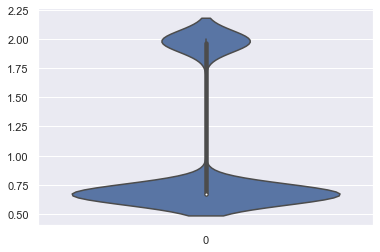

In [122]:
sns.violinplot(data=rw_bal.instance_weights)
plt.show()

### Dataset metrics

In [123]:
rw_metrics = compute_dataset_fairness_metrics(rw_bal, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Classification metrics

Balanced accuracy: 0.6706
Statistical parity difference: 0.0342
Disparate impact: 1.0690
Average odds difference: 0.0342
Equal opportunity difference: 0.0290
Theil index: 0.2099


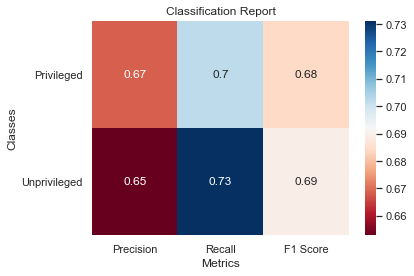

In [124]:
rw_metrics = classify_rw(make_pipeline(StandardScaler(), LogisticRegression()), rw_bal)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


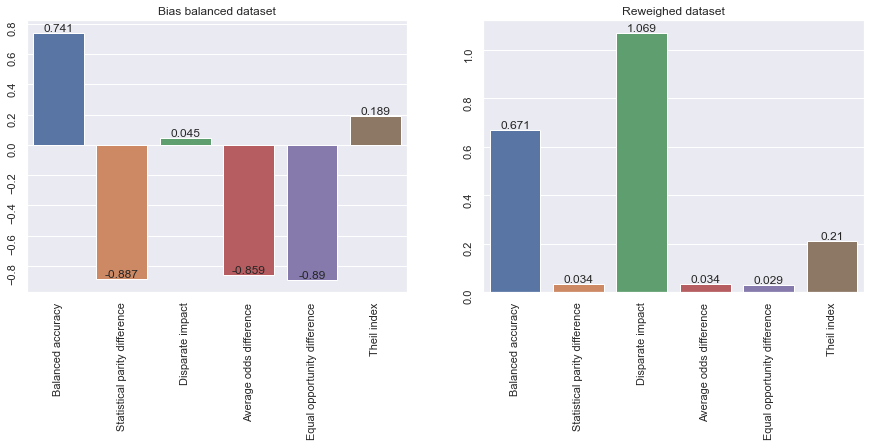

In [125]:
plot_metrics_comparison(bias_bal_metrics, rw_metrics, 'Bias balanced dataset', 'Reweighed dataset')
plt.show()

## Disparate Impact Remover

In [126]:
dir_bal = bias_bal_bin.copy()
scaler = MinMaxScaler()
dir_bal.features = scaler.fit_transform(dir_bal.features)
dr = DisparateImpactRemover(sensitive_attribute='s')
dir_bal = dr.fit_transform(dir_bal)

### Dataset metrics

In [127]:
dir_metrics = compute_dataset_fairness_metrics(dir_bal, unprivileged_group, privileged_group)

Disparate Impact = 0.3406
Statistical Parity = -0.4964


### Classification metrics

Balanced accuracy: 0.6317
Statistical parity difference: 0.0069
Disparate impact: 1.0147
Average odds difference: 0.1822
Equal opportunity difference: 0.1855
Theil index: 0.2248


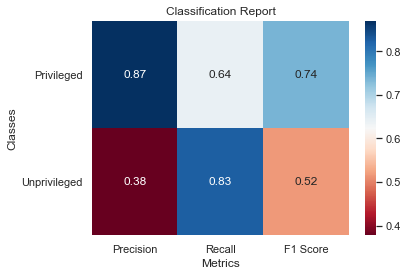

In [128]:
dir_score = classify_dir(make_pipeline(StandardScaler(), LogisticRegression()), dir_bal)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


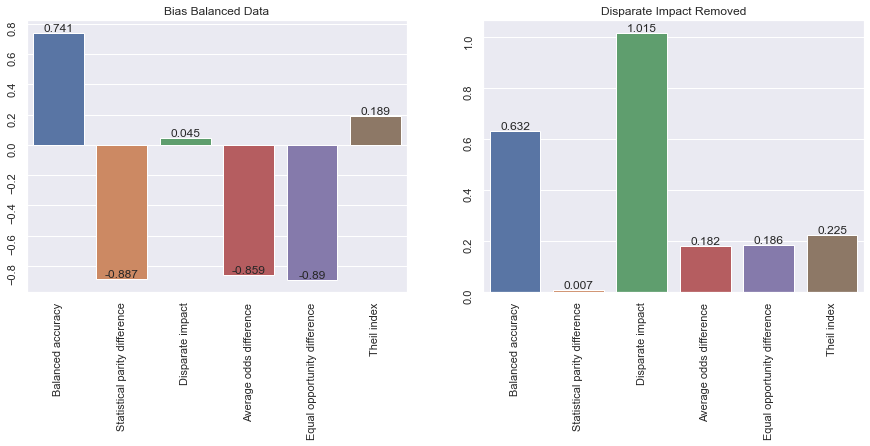

In [148]:
plot_metrics_comparison(bias_bal_metrics, dir_score, 'Bias Balanced Data', 'Disparate Impact Removed')
plt.show()

## Reweighing vs Disparate Impact Remover

In [130]:
bal_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


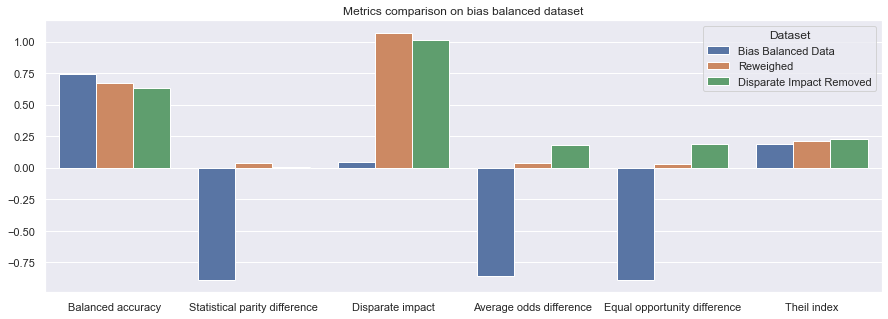

In [131]:
plot_syntesis(bal_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()

# Comparison of the three datasets

Here we compare the metrics for the three versions of the dataset and the methods applied:

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


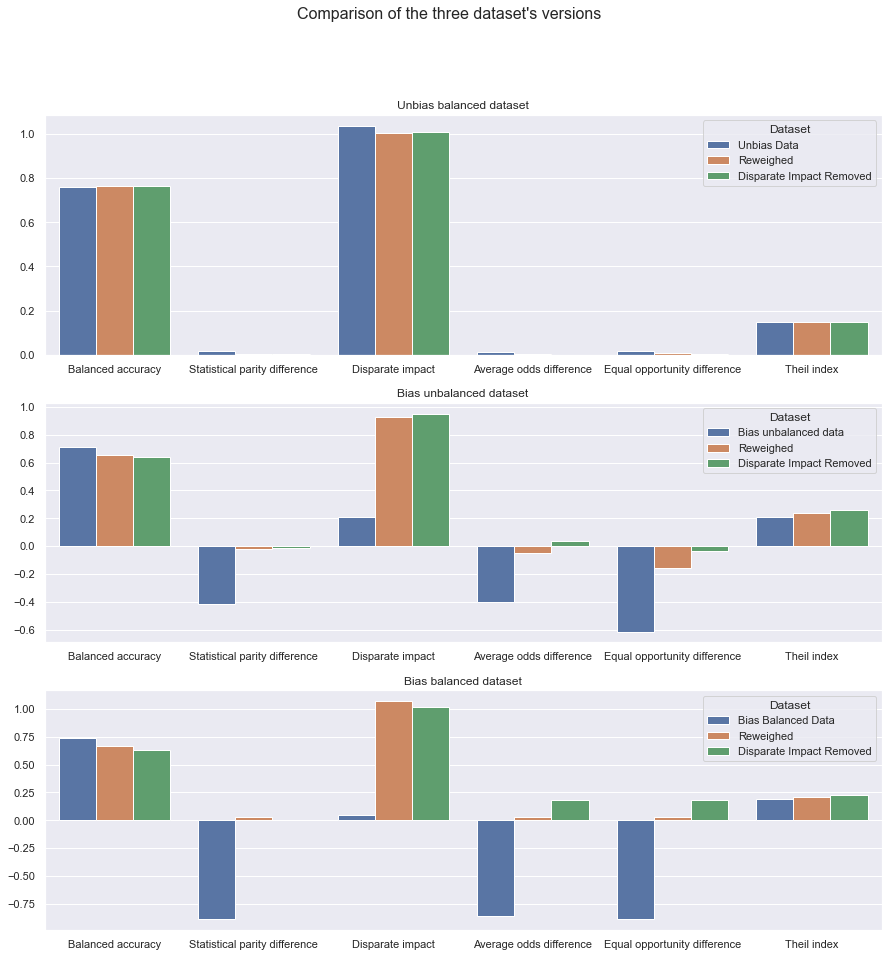

In [132]:
fig, axes = plt.subplots(3,1,figsize=(15,15))
sns.barplot(data=un_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[0],)
sns.barplot(data=unbal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[1])
sns.barplot(data=bal_merged_metrics, x='metrics', y='values', hue='Dataset',ax=axes[2])
for ax in axes:
    ax.set(xlabel='', ylabel='')
axes[0].set_title('Unbias balanced dataset')
axes[1].set_title('Bias unbalanced dataset')
axes[2].set_title('Bias balanced dataset')
fig.suptitle("Comparison of the three dataset's versions", fontsize=16)
plt.show()

# Combine Reweighing and DIR

As can be seen from the charts above both RW and DIR performs well in mitigating the unfairness of the classifier. However both have some lacks:

1. Reweighing requires that a classifier takes account of instance weights, but not all the classifier models do so
2. Disparate Impact Remover has no effect on the dataset fairness metrics but only on the classifier metrics

To solve these problems we will now try to combine these two algorithms by applying the instance weights to the DIR modified dataset and see the results.

## Test with unbias data

In [133]:
un_rw_dir = dir_unb_data.copy(deepcopy=True)
rw = Reweighing(unprivileged_group, privileged_group)
un_rw_dir = rw.fit_transform(un_rw_dir)

In [134]:
score = compute_dataset_fairness_metrics(un_rw_dir, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.7640
Statistical parity difference: 0.0028
Disparate impact: 1.0071
Average odds difference: 0.0034
Equal opportunity difference: 0.0054
Theil index: 0.1470


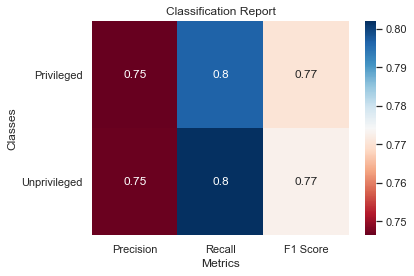

In [135]:
unb_rw_dir_score = classify_dir(make_pipeline(StandardScaler(), LogisticRegression()), un_rw_dir)

In [136]:
un_rw_dir_merg =  merge_datasets({
    'Unbias Data': class_metrics,
    'Reweighed': rw_un_metrics,
    'Disparate Impact Removed': dir_fair_metrics,
    'RW + DIR': unb_rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


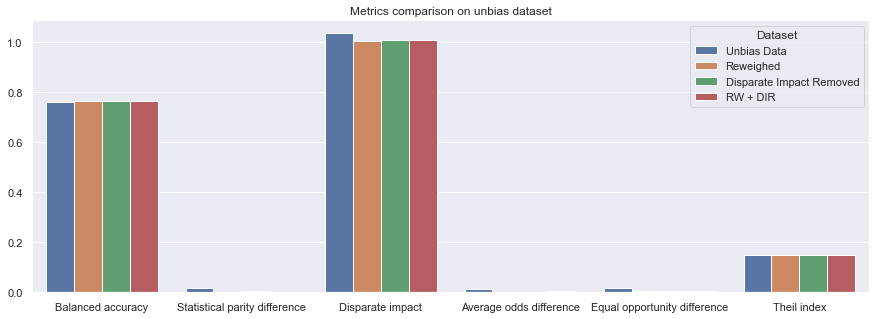

In [137]:
plot_syntesis(un_rw_dir_merg, 'Metrics comparison on unbias dataset')
plt.show()

## Test with unbalance bias data

In [138]:
unbal_dir_rw_data = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
unbal_dir_rw_data = rw.fit_transform(unbal_dir_rw_data)

In [139]:
score = compute_dataset_fairness_metrics(unbal_dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = -0.0000


Balanced accuracy: 0.6487
Statistical parity difference: 0.0598
Disparate impact: 1.2202
Average odds difference: 0.0414
Equal opportunity difference: -0.0324
Theil index: 0.2518


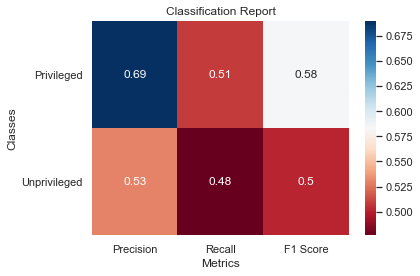

In [140]:
rw_dir_score = classify_dir(make_pipeline(StandardScaler(), LogisticRegression()), unbal_dir_rw_data)

In [141]:
unbal_rw_dir_score = merge_datasets({
    'Bias unbalanced data':  bias_class_metrics,
    'Reweighed': rw_class_metrics,
    'Disparate Impact Removed': dir_class_metrics,
    'RW + DIR': rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


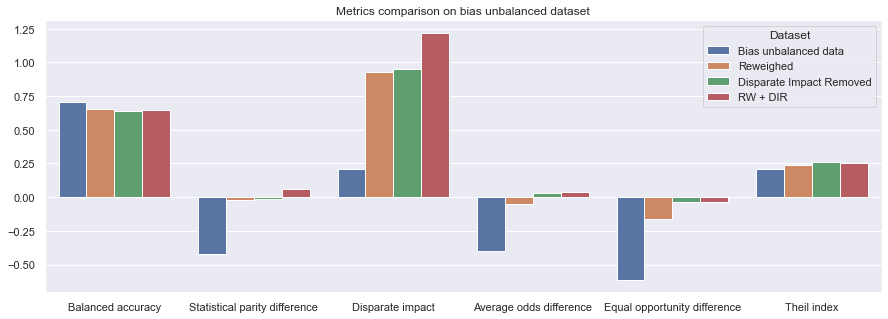

In [142]:
plot_syntesis(unbal_rw_dir_score, 'Metrics comparison on bias unbalanced dataset')
plt.show()

## Test with balanced bias data

In [143]:
dir_rw_data = dir_bal.copy()
rw = Reweighing(unprivileged_group, privileged_group)
dir_rw_data = rw.fit_transform(dir_rw_data)

In [144]:
score = compute_dataset_fairness_metrics(dir_rw_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


Balanced accuracy: 0.6752
Statistical parity difference: 0.1819
Disparate impact: 1.4044
Average odds difference: 0.1825
Equal opportunity difference: 0.1886
Theil index: 0.2293


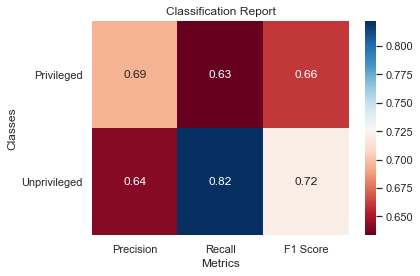

In [145]:
rw_dir_score = classify_dir(make_pipeline(StandardScaler(),LogisticRegression()), dir_rw_data)

In [146]:
rw_dir_merged_metrics = merge_datasets({
    'Bias Balanced Data': bias_bal_metrics,
    'Reweighed': rw_metrics,
    'Disparate Impact Removed': dir_score,
    'RW + DIR': rw_dir_score
})

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


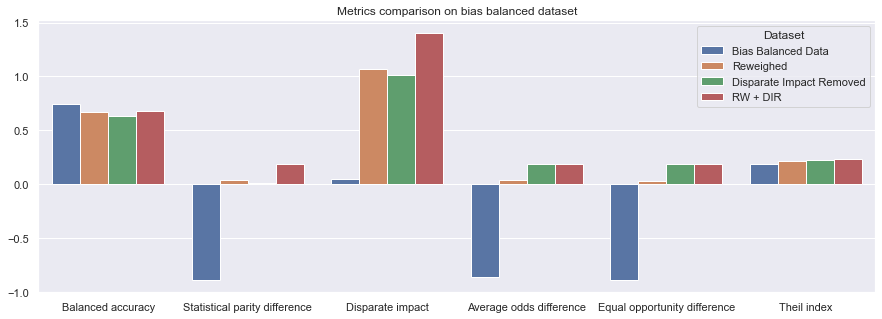

In [147]:
plot_syntesis(rw_dir_merged_metrics, 'Metrics comparison on bias balanced dataset')
plt.show()